In [22]:
# Import packages & libraries
import os # Interoperable file paths
import pathlib # Find the home folder
import re # Extract metadata from file names
import zipfile # Work with zip files
from io import BytesIO # Stream binary (zip) files; stream zipped data from the internet like it was a file
from glob import glob # Import library to find files by pattern

import cartopy.crs as ccrs # CRSs
import earthaccess # Access NASA data from the cloud
import geopandas as gpd # Work with vector data
import hvplot.pandas # Interactive plots of vector data
import hvplot.xarray # Interactive raster
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import numpy as np # Unpack bit-wise Fmask
import pandas as pd # Group and aggregate
import regionmask # Convert shapefile to mask
import requests # Request data over HTTP
import rioxarray as rxr # Work with geospatial raster data
from rioxarray.merge import merge_arrays # Merge rasters
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
import xarray as xr # Adjust images
from xrspatial import zonal_stats # Calculate zonal statistics

In [23]:
# Create data directory
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'bld-co-redlining'
)

os.makedirs(data_dir, exist_ok=True)

data_dir

'C:\\Users\\riede\\earth-analytics\\data\\bld-co-redlining'

c:\Users\riede\miniconda3\envs\earth-analytics-python\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\riede\earth-analytics\data\bld-co-redlining\mappinginequalityboulder\redlining.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


<Axes: >

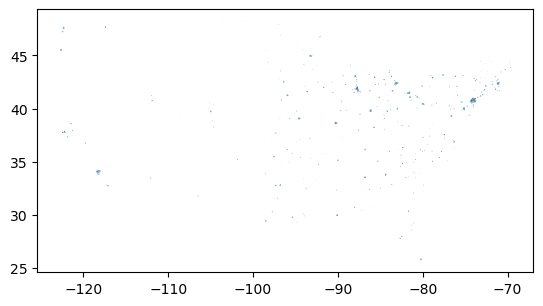

In [24]:
# Define and download redlining data
redlining_url = (
    "https://dsl.richmond.edu/panorama/redlining/static"
    "/mappinginequality.gpkg"
)

redlining_dir = os.path.join(
    data_dir,
    'mappinginequalityboulder'
)

os.makedirs(redlining_dir, exist_ok=True)

redlining_path = os.path.join(
    redlining_dir,
    'redlining.shp'
)

# Only download once
if not os.path.exists(redlining_path):
    redlining_gdf = gpd.read_file(redlining_url)
    redlining_gdf.to_file(redlining_path)

# Load from file
redlining_gdf = gpd.read_file(redlining_path)

# Check the data
redlining_gdf.plot()

In [25]:
#Select rows from redlining_gdf only for where Boulder is the city
bld_redlining_gdf = redlining_gdf[redlining_gdf.city=="Boulder"]

In [26]:
#Plot the bld_redlining_gdf with the EsriImagery and dissolve the regions
bld_redlining_gdf.dissolve().hvplot(
    geo=True, tiles='EsriImagery',
    fill_color=None, line_color='pink', line_width=4,
    title='Map Boulder, Colorado with Outline of Redlined Areas',
    frame_width=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

# Define necessary functions

In [27]:
def process_image(uri, bounds_gdf):
    """
    Load, crop, and scale a raster image from earthaccess

    Parameters
    ----------
    uri: file-like or path-like
      File accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster
    """
    #connect to the raster image
    da = rxr.open_rasterio(uri, mask_and_scale=True).squeeze()
    
    # Get the study bounds
    bounds = (
      bounds_gdf
      .to_crs(da.rio.crs)
      .total_bounds
    )

    # Crop
    cropped_da = da.rio.clip_box(*bounds)

    return cropped_da

#process_image(boulder_files[8], bld_redlining_gdf)

In [28]:
def process_cloud_mask(cloud_uri, bounds_gdf, bits_to_mask):
    """
    Load an 8-bit Fmask file and process to a boolean mask

    Parameters
    ----------
    uri: file-like or path-like
      Fmask file accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to
    bits_to_mask: list of int
      The indices of the bits to mask if set

    Returns
    -------
    cloud_mask: np.array
      Cloud mask
    """
    # Open fmask file
    fmask_da = process_image(cloud_uri, bounds_gdf)

    # Unpack the cloud mask bits
    cloud_bits = (
    np.unpackbits(
        (
            # Get the cloud mask as an array by just getting the values so the numpy function can work with it...
            fmask_da.values
            # ... of 8-bit integers
            .astype('uint8')
            # With an extra axis to unpack the bits into, kind of like we're adding a enw dimension, it will include our unpacked 8 bit fmask encoded number
            [:, :, np.newaxis]
        ), 
        # List the least significant bit first to match the user guide; least significant bit is usually last with how we normally write numbers,
        # but because the fmask userguide has the least significant bit first, we need to flip it around. around 1 hr 15 mins in Elsa's video
        bitorder='little',
        # Expand the array in a new dimension
        axis=-1)
    )

    cloud_mask = np.sum(
        # Select bits: everything in x dimension, everything in y dimension, and only the bit layers we want (1, 2, 3, and 5)
        cloud_bits[:,:,bits_to_mask], 
        # Sum along the bit axis
        axis=-1
    # Check if any of bits are true
    ) == 0

    return cloud_mask

# #load in green da with previous function to test
# green_da = process_image(boulder_files[8], bld_redlining_gdf)

# # found cloud_uri by going back to notebook 91, looking at denver_files, and seeing that the Fmask file was the last one, or -1 by indexing
# # found bits_to_mask from notebook 32's bits_to_mask in cell 6
# boulder_cloud_mask = process_cloud_mask(
#     boulder_files[7],
#     bld_redlining_gdf,
#     [1, 2, 3, 5])

# green_da.where(boulder_cloud_mask).plot()

# Get multispectral data from earthaccess

In [29]:
# Log in to earthaccess
earthaccess.login(strategy="interactive", persist=True)

In [30]:
# Search earthaccess for a clear day in Boulder, CO
boulder_results = earthaccess.search_data(
    short_name="HLSL30",
    bounding_box=tuple(bld_redlining_gdf.total_bounds),
    temporal=("2022-07-01")
)
boulder_results

[Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.57693023, 'Latitude': 39.66017406}, {'Longitude': -104.88622009, 'Latitude': 39.66155123}, {'Longitude': -104.88455693, 'Latitude': 40.65079881}, {'Longitude': -105.2819814, 'Latitude': 40.65024197}, {'Longitude': -105.57693023, 'Latitude': 39.66017406}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-07-01T17:37:32.646Z', 'EndingDateTime': '2022-07-01T17:37:56.533Z'}}
 Size(MB): 83.11219596862793
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.SAA.tif', 'https://dat

In [31]:
# Access Boulder, CO HLS data
boulder_files = earthaccess.open(boulder_results)
boulder_files

QUEUEING TASKS | :   0%|          | 0/3135 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3135 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3135 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.B10.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.SAA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.B07.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.B11.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDE.2022182T173732.v2.0/HLS.L30.T13TDE.2022182T173732.v2.0.VAA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earth

<xarray.DataArray (y: 3660, x: 3660)> Size: 54MB
[13395600 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 29kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref  int64 8B 0
Attributes: (12/33)
    ACCODE:                    Lasrc; Lasrc
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    arop_s2_refimg:            NONE
    ...                        ...
    TIRS_SSM_MODEL:            PRELIMINARY; PRELIMINARY
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       399960
    ULY:                       4500000
    USGS_SOFTWARE:             LPGS_16.1.0
    AREA_OR_POINT:             Area

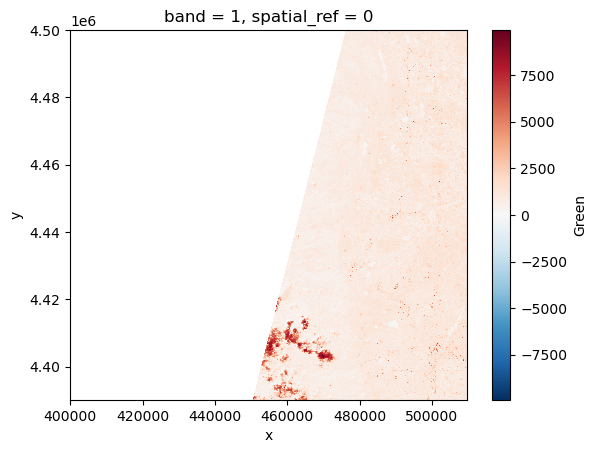

In [10]:
# Import one tile of green data, which is the B03 file
green_da = rxr.open_rasterio(boulder_files[5], mask_and_scale=True).squeeze()
display(green_da)
green_da.plot()

<xarray.DataArray (y: 3660, x: 3660)> Size: 27MB
[13395600 values with dtype=int16]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 29kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
    spatial_ref  int64 8B 0
Attributes: (12/36)
    ACCODE:                    Lasrc; Lasrc
    add_offset:                0.0
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    ...                        ...
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       399960
    ULY:                       4500000
    USGS_SOFTWARE:             LPGS_16.1.0
    AREA_OR_POINT:             Area
    _FillValue:                -9999

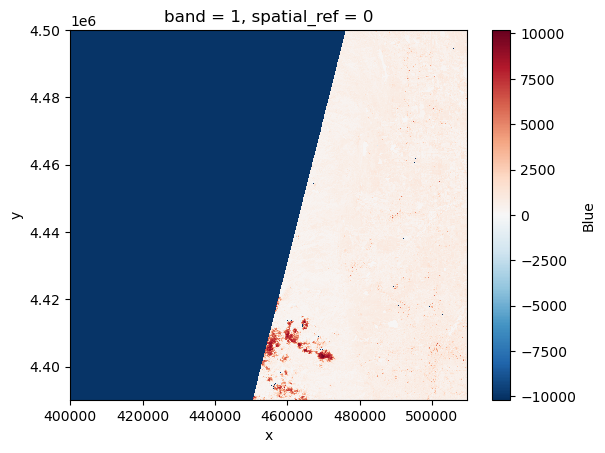

In [11]:
# Import one tile of blue data, which is the B02 file
blue_da = rxr.open_rasterio(boulder_files[13]).squeeze()
display(blue_da)
blue_da.plot()